## Import Dependencies

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

## Load and Explore Data

In [48]:
import pickle

# Load the pickle file
with open('data/train_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Access images and labels
images = data['images']
labels = data['labels']

In [49]:
images.shape

(1080, 28, 28, 3)

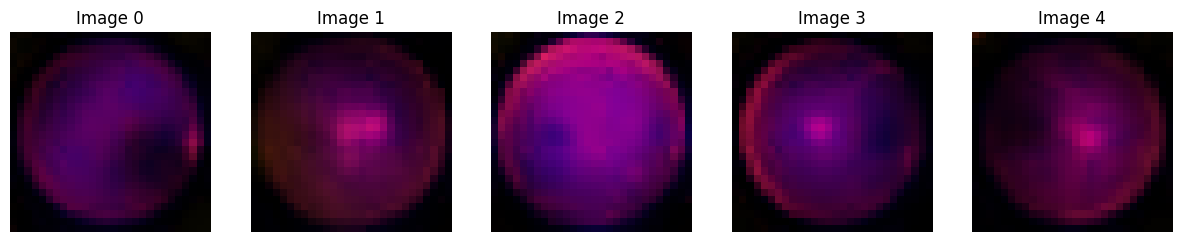

In [232]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 5 columns
# figsize=(width, height) controls how big the overall image is
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    # Select the image
    img_data = images[i]
    
    # Optional: Normalize if your data is float 0-255
    # img_data = images[i] / 255.0 
    
    # Plot on the specific axis (subplot)
    axes[i].imshow(img_data)
    axes[i].axis('off')  # Hide the axis numbers for a cleaner look
    axes[i].set_title(f"Image {i}")

plt.show()

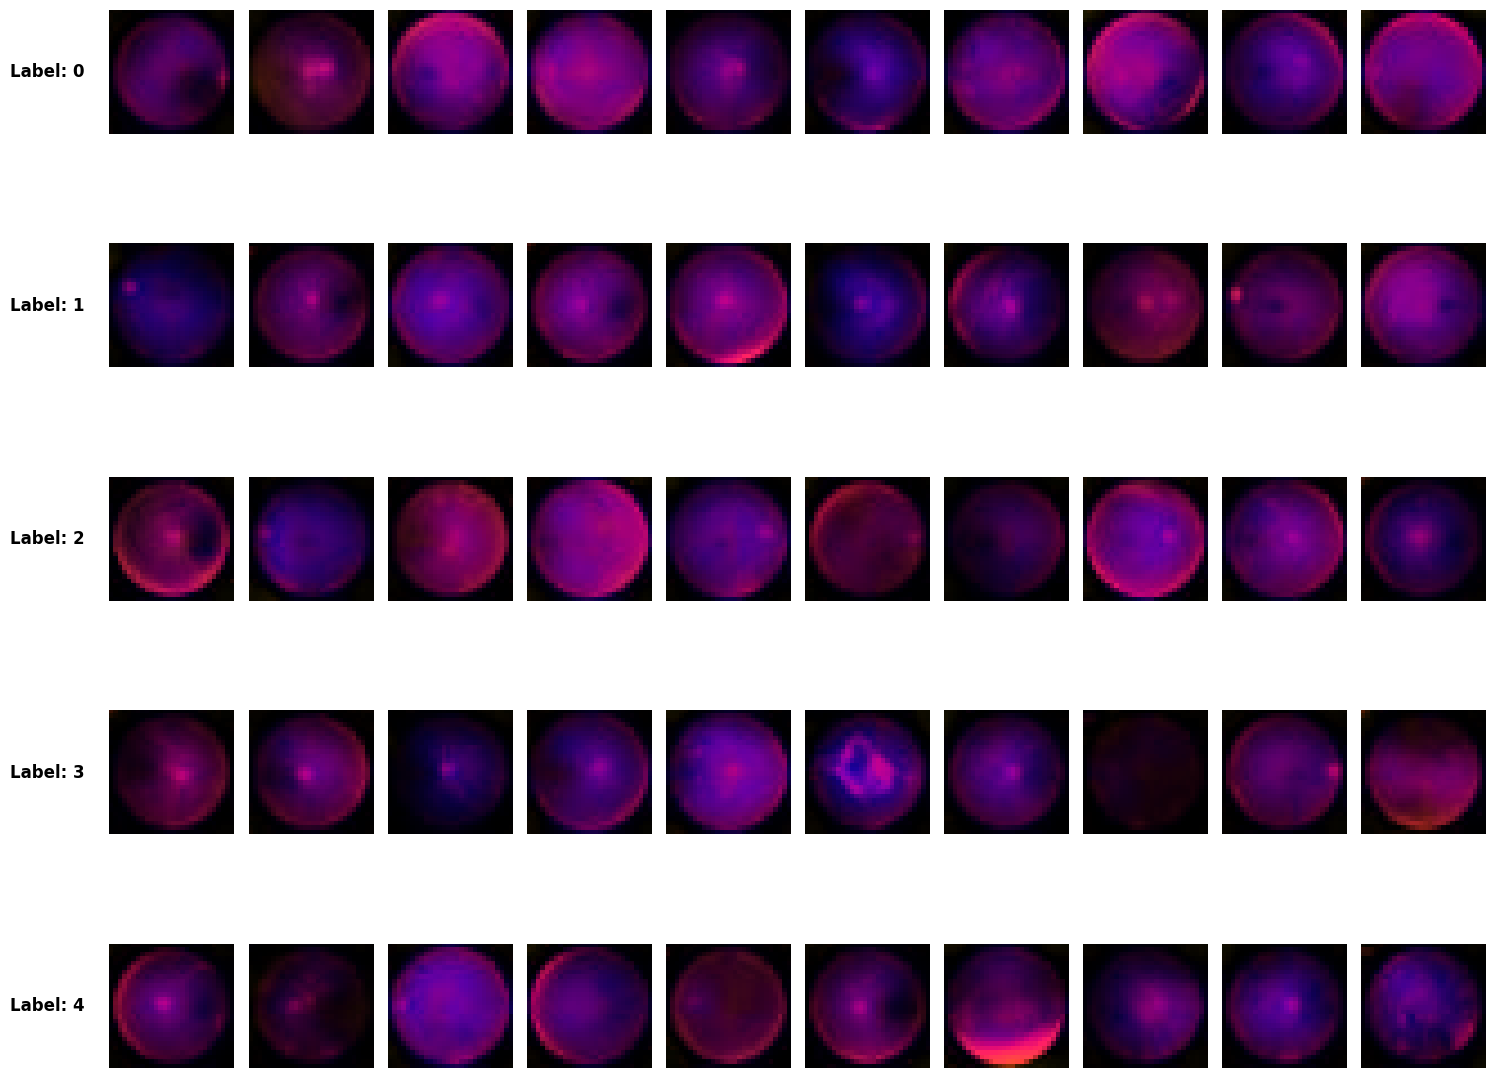

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get unique classes
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# 2. Create a big figure: Rows = Number of Classes, Cols = 10 samples
fig, axes = plt.subplots(num_classes, 10, figsize=(15, 2.5 * num_classes))

# 3. Loop through each class and plot
for i, current_label in enumerate(unique_labels):
    # Find indices of all images with this label
    # We use [0] because np.where returns a tuple
    idxs = np.where(labels == current_label)[0]
    
    # Take the first 10 (or fewer if less than 10 exist)
    sample_idxs = idxs[:10]
    
    for j in range(10):
        ax = axes[i, j] if num_classes > 1 else axes[j]
        
        if j < len(sample_idxs):
            # Get the image
            img_idx = sample_idxs[j]
            img = images[img_idx]
            
            # Normalize if necessary (fixes white image issue)
            if img.dtype.kind == 'f' and img.max() > 1:
                img = img / 255.0
                
            ax.imshow(img)
        
        # Clean up axes
        ax.axis('off')
        
        # Add label text only on the first column of the row
        if j == 0:
            ax.text(-0.2, 0.5, f"Label: {current_label}", 
                    transform=ax.transAxes, 
                    fontsize=12, va='center', ha='right', fontweight='bold')

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=uint8)


--- Search for Intensity 10 ---
Target Range: [5.00, 15.00]


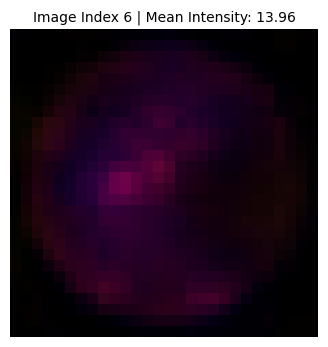

RESULT: Visualizing the first match found at index 6.


In [189]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_first_image_by_intensity(
    images, 
    target_intensity, 
    tolerance=5
):
    """
    Finds and visualizes the first image in the array whose mean intensity 
    falls within the specified range [target_intensity - tolerance, target_intensity + tolerance].
    
    The function automatically detects if the input is grayscale (N, H, W, 1) or color (N, H, W, 3).

    :param images: Image array (N, H, W, C), assumed to be 0-255 scaled.
    :param target_intensity: The central intensity value to target (0-255).
    :param tolerance: Half the width of the intensity band (e.g., 5).
    """
    
    # Check if the array is 4-dimensional (N, H, W, C)
    if images.ndim != 4:
        print("Error: Input array 'images' must be 4-dimensional (N, H, W, C).")
        return
        
    # Determine plotting structure based on channel count
    channel_count = images.shape[-1]
    is_grayscale = (channel_count == 1)
    
    # 1. Calculate the mean intensity for each image across all spatial/channel axes
    # The result is a 1D array of shape (N,)
    # Uses axis=(-3, -2, -1) to target the H, W, and C axes efficiently.
    mean_intensities = np.mean(images, axis=(-3, -2, -1))

    # 2. Define the intensity bounds
    lower_bound = target_intensity - tolerance
    upper_bound = target_intensity + tolerance
    
    # 3. Create a boolean mask: True for images within the range
    valid_mask = (mean_intensities >= lower_bound) & (mean_intensities <= upper_bound)
    
    # 4. Find the index of the first match
    match_indices = np.where(valid_mask)[0]
    
    print(f"\n--- Search for Intensity {target_intensity} ---")
    print(f"Target Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    if len(match_indices) == 0:
        print("RESULT: No image found in the specified range.")
        return

    # Get the index of the very first matching image
    first_index = match_indices[0]
    first_image = images[first_index]
    actual_mean = mean_intensities[first_index]
    
    # --- 5. Plot the Single Image ---
    
    plt.figure(figsize=(4, 4))
    
    if is_grayscale:
        # Squeeze removes the redundant channel dimension (H, W, 1) -> (H, W) for plotting
        image_to_plot = np.squeeze(first_image, axis=-1)
        # Use cmap='gray' for proper grayscale display
        plt.imshow(image_to_plot, cmap='gray', vmin=0, vmax=255)
    else:
        # Assumes color (H, W, 3). Converts to uint8 for correct color rendering.
        plt.imshow(first_image.astype(np.uint8)) 

    plt.title(f"Image Index {first_index} | Mean Intensity: {actual_mean:.2f}", fontsize=10)
    plt.axis('off')
    plt.show()
    
    print(f"RESULT: Visualizing the first match found at index {first_index}.")

# --- INTENDED USAGE EXAMPLE (Assuming you have an array named 'images') ---
visualize_first_image_by_intensity(images, target_intensity=10, tolerance=5)

In [50]:
def one_hot_encode(Y_sparse, num_classes): #we have 5 classes: 0,1,2,3,4
    """
    Converts a sparse label vector (Y_sparse) into a one-hot encoded matrix.

    :param Y_sparse: 1D array of integer labels (e.g., [0, 1, 2, 0])
    :param num_classes: Total number of unique classes (K)
    :return: 2D NumPy array in shape (K, M) for the WX convention
    """
    # 1. Create the identity matrix (K, K)
    # The identity matrix (np.eye(K)) acts as a lookup table.
    # np.eye(3) -> [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # 2. Use sparse labels as indices
    # This selects the appropriate row from the identity matrix for each label.
    one_hot_matrix = np.eye(num_classes)[Y_sparse] # Shape: (M, K)

    # 3. Transpose for the WX convention
    # Convert (Samples, Classes) to (Classes, Samples) -> (K, M)
    return one_hot_matrix.T


--- Search for Intensity 15 ---
Target Range: [14.00, 16.00]


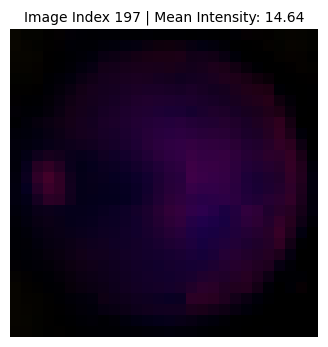

RESULT: Visualizing the first match found at index 197.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_first_image_by_intensity(
    images, 
    target_intensity, 
    tolerance=1
):
    """
    Finds and visualizes the first image in the array whose mean intensity 
    falls within the specified range [target_intensity - tolerance, target_intensity + tolerance].
    
    The function automatically detects if the input is grayscale (N, H, W, 1) or color (N, H, W, 3).

    :param images: Image array (N, H, W, C), assumed to be 0-255 scaled.
    :param target_intensity: The central intensity value to target (0-255).
    :param tolerance: Half the width of the intensity band (e.g., 5).
    """
    
    # Check if the array is 4-dimensional (N, H, W, C)
    if images.ndim != 4:
        print("Error: Input array 'images' must be 4-dimensional (N, H, W, C).")
        return
        
    # Determine plotting structure based on channel count
    channel_count = images.shape[-1]
    is_grayscale = (channel_count == 1)
    
    # 1. Calculate the mean intensity for each image across all spatial/channel axes
    # The result is a 1D array of shape (N,)
    # Uses axis=(-3, -2, -1) to target the H, W, and C axes efficiently.
    mean_intensities = np.mean(images, axis=(-3, -2, -1))

    # 2. Define the intensity bounds
    lower_bound = target_intensity - tolerance
    upper_bound = target_intensity + tolerance
    
    # 3. Create a boolean mask: True for images within the range
    valid_mask = (mean_intensities >= lower_bound) & (mean_intensities <= upper_bound)
    
    # 4. Find the index of the first match
    match_indices = np.where(valid_mask)[0]
    
    print(f"\n--- Search for Intensity {target_intensity} ---")
    print(f"Target Range: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    if len(match_indices) == 0:
        print("RESULT: No image found in the specified range.")
        return

    # Get the index of the very first matching image
    first_index = match_indices[0]
    first_image = images[first_index]
    actual_mean = mean_intensities[first_index]
    
    # --- 5. Plot the Single Image ---
    
    plt.figure(figsize=(4, 4))
    
    if is_grayscale:
        # Squeeze removes the redundant channel dimension (H, W, 1) -> (H, W) for plotting
        image_to_plot = np.squeeze(first_image, axis=-1)
        # Use cmap='gray' for proper grayscale display
        plt.imshow(image_to_plot, cmap='gray', vmin=0, vmax=255)
    else:
        # Assumes color (H, W, 3). Converts to uint8 for correct color rendering.
        plt.imshow(first_image.astype(np.uint8)) 

    plt.title(f"Image Index {first_index} | Mean Intensity: {actual_mean:.2f}", fontsize=10)
    plt.axis('off')
    plt.show()
    
    print(f"RESULT: Visualizing the first match found at index {first_index}.")

# --- INTENDED USAGE EXAMPLE (Assuming you have an array named 'images') ---
visualize_first_image_by_intensity(images, target_intensity=15, tolerance=1)

In [51]:
import numpy as np

# A common safe threshold for 0-255 scaled images is 5-10.
# If the average pixel intensity is below 8, we discard the image.
INTENSITY_THRESHOLD = 20

def filter_black_images(X_data, Y_data, threshold=INTENSITY_THRESHOLD):
    """
    Filters out images where the average pixel intensity is below a threshold.

    :param X_data: Image array (e.g., N, 28, 28, 3)
    :param Y_data: Corresponding label array (e.g., N, 5)
    :param threshold: The average pixel value below which an image is considered 'black'.
    :return: Filtered X and Y arrays
    """
    
    # 1. Calculate the mean intensity for *each image* across all its dimensions (H, W, C).
    # The result is a 1D array of shape (N,)
    mean_intensities = np.mean(X_data, axis=(1, 2, 3))
    
    # 2. Create a boolean mask: True for images that are bright enough
    valid_mask = mean_intensities > threshold
    
    # 3. Apply the mask to both the image data (X) and the labels (Y)
    X_filtered = X_data[valid_mask]
    Y_filtered = Y_data[valid_mask]
    
    print(f"Original samples: {len(X_data)}")
    print(f"Filtered samples: {len(X_filtered)}")
    print(f"Removed: {len(X_data) - len(X_filtered)}")
    
    return X_filtered, Y_filtered

In [52]:
# Assuming your arrays are X_train, Y_train, X_val, Y_val (using color images)

# Filter the Training Set
images, labels = filter_black_images(images, labels)

# Filter the Validation Set
# etc.

Original samples: 1080
Filtered samples: 1016
Removed: 64


In [53]:
# This reduces the last dimension from 3 to 1

# 1. Define the weights for R, G, B
rgb_weights = [0.299, 0.587, 0.114]
# This reduces the last dimension from 3 to 1
images_gray = np.dot(images[..., :3], rgb_weights)



images_flattened = images_gray.reshape(images_gray.shape[0], -1)
images_normalized = images_flattened / 255.0
labels_encoded = one_hot_encode(labels.flatten(), num_classes=5)
X = (images_normalized).T  # Shape: (Features, Samples)
Y = labels_encoded       # Shape: (Classes, Samples)
Y

array([[1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
def train_val_split(X, Y, val_ratio=0.2, random_seed=42):
    """
    Splits transposed X (Features, Samples) and Y (Classes, Samples)
    into training and validation sets.
    """
    # 1. Set the random seed for reproducibility
    np.random.seed(random_seed)

    # 2. Determine the number of samples (M)
    # Since X is (Features, Samples), M is the second dimension (axis 1)
    M = X.shape[1]

    # 3. Create a shuffled array of indices from 0 to M-1
    indices = np.arange(M)
    np.random.shuffle(indices)

    # 4. Calculate the split point
    val_size = int(M * val_ratio)

    # 5. Define the split indices
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    # 6. Split the data arrays (using advanced indexing on the Samples axis)
    # The indices array is used to select the columns (samples) in the desired order
    X_train = X[:, train_indices]
    Y_train = Y[:, train_indices]

    X_val = X[:, val_indices]
    Y_val = Y[:, val_indices]

    return X_train, X_val, Y_train, Y_val
X_train, X_val, Y_train, Y_val = train_val_split(
    X,
    Y,
    val_ratio=0.2,
    random_seed=42
)

In [66]:
import numpy as np

def get_expert_subset(X_train, Y_train):
    """
    Extracts the subset of training data (X_train) and relabeled one-hot 
    labels (Y_expert) corresponding only to original classes 1 and 4.
    
    Assumes: 
    - X_train is transposed (Features, Samples) e.g., (784, 813)
    - Y_train is One-Hot Encoded (Classes, Samples) e.g., (5, 813)
    
    :param X_train: Feature array (D, M).
    :param Y_train: OHE label array (K, M).
    :return: X_expert (D, M_new), Y_expert_ohe (2, M_new)
    """
    
    # 1. Convert OHE to integer labels (M,) to identify the true class
    # np.argmax along axis=0 gives the class index for each sample (column)
    y_sparse = np.argmax(Y_train, axis=0) 
    
    # 2. Create Boolean Mask (length M)
    # Checks if the label is 1 OR 4 for each sample
    mask = (y_sparse == 1) | (y_sparse == 4)
    
    # 3. Apply Mask to Columns (axis 1) of the Feature Array
    X_expert = X_train[:, mask] 
    y_expert_sparse = y_sparse[mask]
    
    samples_kept = X_expert.shape[1]
    
    print(f"Total original samples: {Y_train.shape[1]}")
    print(f"Samples filtered for Expert Network (Classes 1 & 4): {samples_kept}")
    
    # 4. Relabeling (1 -> 0, 4 -> 1)
    # Create the new sparse label vector (0 or 1)
    # np.where(condition, value_if_true, value_if_false)
    y_expert_relabel_sparse = np.where(y_expert_sparse == 1, 0, 1)
    
    # 5. Convert Relabeled Sparse Array to Expert OHE (2 x M_new)
    K_expert = 2 # The new number of classes
    Y_expert_ohe = np.zeros((K_expert, samples_kept))
    
    # Set the '1' at the appropriate row (0 or 1)
    Y_expert_ohe[y_expert_relabel_sparse, np.arange(samples_kept)] = 1
    
    return X_expert, Y_expert_ohe

# --- EXAMPLE USAGE ---
X_expert_train, Y_expert_train_ohe = get_expert_subset(X_train, Y_train)
X_expert_val, Y_expert_val_ohe = get_expert_subset(X_val, Y_val)

Total original samples: 813
Samples filtered for Expert Network (Classes 1 & 4): 152
Total original samples: 203
Samples filtered for Expert Network (Classes 1 & 4): 24


## Train Models

Train and compare multiple machine learning models.

In [105]:
class DeepNN: #we will try 28x28 layers, with relu for each activation except the last layer which will be softmax
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size, random_seed=42):
        """

        :param input_size: Number of features
        :param hidden_size: Number of neurons in the hidden layer
        :param output_size: Number of neurons in the output layer.
        Initialize weights and biases for a 1-hidden layer neural network
        :
        """
        np.random.seed(random_seed)
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((hidden_size_2, 1))
        self.b3 = np.zeros((output_size, 1))

        std_dev = np.sqrt(2 / input_size)
        self.W1 = np.random.randn(hidden_size, input_size) * std_dev

        std_dev_2 = np.sqrt(2 / hidden_size)
        self.W2 = np.random.randn(hidden_size_2, hidden_size) * std_dev_2

        std_dev_3 = np.sqrt(2 / hidden_size_2)
        self.W3 = np.random.randn(output_size, hidden_size_2) * std_dev_3

    def _leaky_relu(self, Z, alpha=0.01):
        return np.maximum(alpha * Z, Z) # Leaky ReLU activation
    def _softmax(self, Z):
        """Softmax activation for the Output Layer."""
        # Ensure numerical stability by subtracting max(Z)
        exp_z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    def _leaky_relu_derivative(self, A, alpha=0.01):
        # A should be the output of _leaky_relu (A1 or A2)
        dA = np.ones_like(A)
        dA[A <= 0] = alpha
        return dA
    def forward_propagate(self, X):
        #Input X must be transposed: (D, M) -> (Features, Samples)
        ### 1st matrix multiplication
        ### Z1 = W1*X + b1 -> then apply activation function
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = self._leaky_relu(self.Z1)
        ### 2nd matrix multiplication
        ### Z2 = W2*LastOutput+ b2 -> then apply activation function
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self._leaky_relu(self.Z2)

        self.Z3 = np.dot(self.W3, self.A2) + self.b3
        self.A3 = self._softmax(self.Z3)

        return self.A3
    def back_propagate(self, X, Y, learning_rate):
        """Performs the backward pass and updates weights/biases."""
        m = X.shape[1]  # number of samples

        #1. Calculate output layer error

        dZ3 = self.A3 - Y
        dW3 = (1 / m) * np.dot(dZ3, self.A2.T)
        db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

        dA2 = np.dot(self.W3.T, dZ3)
        dZ2 = dA2 * self._leaky_relu_derivative(self.A2)

        dW2 = (1 / m) * np.dot(dZ2, self.A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)



        #3. Calculate hidden layer error
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * self._leaky_relu_derivative(self.A1)

        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        # 5. Update Weights and Biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
    def _calculate_loss(self, Y_true, Y_hat):
        """Calculates the cross-entropy loss."""
        m = Y_true.shape[1]
        loss = -np.sum(Y_true * np.log(Y_hat + 1e-9)) / m
        return loss

    def train(self, X_train, Y_train, X_valid, Y_valid, epochs=1000, learning_rate=0.01, log_interval=10):
        """Trains the neural network using the provided training data."""
        train_loss_history = []
        valid_loss_history = []
        for epoch in range(epochs):
            if epoch > 0 and epoch % 500 == 0:
                learning_rate *= 0.5
                print(f"Epoch {epoch}: LR decayed to {learning_rate:.5f}")
            # Forward propagation
            Y_hat_train = self.forward_propagate(X_train)
            # Backward propagation
            self.back_propagate(X_train, Y_train, learning_rate)

            if epoch % log_interval == 0 or epoch == 1:
                train_loss = self._calculate_loss(Y_train, Y_hat_train)
                train_loss_history.append(train_loss)

                Y_hat_valid = self.forward_propagate(X_valid)
                valid_loss = self._calculate_loss(Y_valid, Y_hat_valid)
                valid_loss_history.append(valid_loss)
                #print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
                print(f"Epoch {epoch:<4}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")
        return train_loss_history, valid_loss_history
    def predict(self, X):
        """Generates binary predictions (0 or 1)."""
        probs = self.forward_propagate(X)
        return np.argmax(probs, axis=0), probs # argmax along the output unit dimension


Epoch 0   , Train Loss: 1.5595, Val Loss: 1.5169
Epoch 1   , Train Loss: 1.5338, Val Loss: 1.4915
Epoch 20  , Train Loss: 1.3634, Val Loss: 1.2679
Epoch 40  , Train Loss: 1.3389, Val Loss: 1.2295
Epoch 60  , Train Loss: 1.3280, Val Loss: 1.2150
Epoch 80  , Train Loss: 1.3195, Val Loss: 1.2043
Epoch 100 , Train Loss: 1.3121, Val Loss: 1.1957
Epoch 120 , Train Loss: 1.3054, Val Loss: 1.1880
Epoch 140 , Train Loss: 1.2992, Val Loss: 1.1812
Epoch 160 , Train Loss: 1.2931, Val Loss: 1.1745
Epoch 180 , Train Loss: 1.2874, Val Loss: 1.1682
Epoch 200 , Train Loss: 1.2820, Val Loss: 1.1621
Epoch 220 , Train Loss: 1.2767, Val Loss: 1.1564
Epoch 240 , Train Loss: 1.2719, Val Loss: 1.1512
Epoch 260 , Train Loss: 1.2675, Val Loss: 1.1462
Epoch 280 , Train Loss: 1.2634, Val Loss: 1.1414
Epoch 300 , Train Loss: 1.2595, Val Loss: 1.1367
Epoch 320 , Train Loss: 1.2559, Val Loss: 1.1324
Epoch 340 , Train Loss: 1.2524, Val Loss: 1.1284
Epoch 360 , Train Loss: 1.2491, Val Loss: 1.1247
Epoch 380 , Train Lo

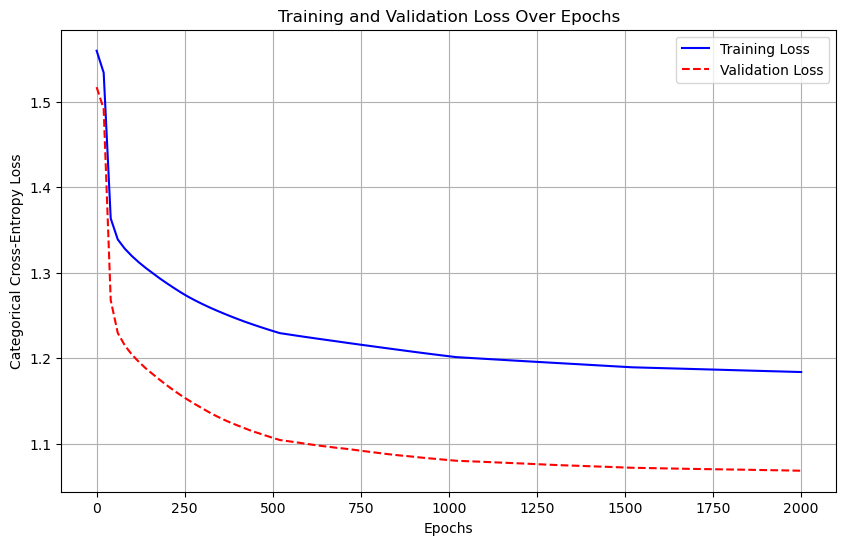

In [106]:
import matplotlib.pyplot as plt
# import numpy as np # Assumed imported

# 1. SETUP AND TRAINING CALL (Assuming X, Y, and train_val_split are defined)

# You must set these variables for the call:
EPOCHS = 2000  # Example value ###1500 gives accuracy of 0.5 with hidden dim = 10, learning rate = 0.05
LEARNING_RATE = 0.05 # Example value
HIDDEN_DIM = 150 # Example value
HIDDEN_DIM_2 = 50 # Example value``
LOG_INTERVAL = 20 # How often to record loss

# Initialize NN (using dimensions from the split data)
INPUT_DIM = X_train.shape[0]
OUTPUT_DIM = Y_train.shape[0]

nn = DeepNN(INPUT_DIM, HIDDEN_DIM, HIDDEN_DIM_2,  OUTPUT_DIM)

# Train the model and get the loss histories
train_loss, val_loss = nn.train(
    X_train, Y_train,
    X_val, Y_val,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    log_interval=LOG_INTERVAL
)

# 1. Use the length of the actual data returned by the training
actual_length = len(train_loss)

# 2. Generate indices based on that length
# This ensures x and y are always the same size, regardless of EPOCHS settings
epochs_to_plot = np.arange(actual_length) * LOG_INTERVAL

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_plot, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_to_plot, val_loss, label='Validation Loss', color='red', linestyle='--')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig('loss_curve.png') # Use this if running in a non-interactive environment

In [112]:
# Predict on Training Set
train_preds, train_preds_proba = nn.predict(X_train)
# Convert Y_train from One-Hot (K, M) to Sparse (M,)
Y_train_sparse = np.argmax(Y_train, axis=0)
train_acc = np.mean(train_preds == Y_train_sparse)

# Predict on Validation Set
val_preds, val_preds_proba = nn.predict(X_val)
# Convert Y_val from One-Hot (K, M) to Sparse (M,)
Y_val_sparse = np.argmax(Y_val, axis=0)
val_acc = np.mean(val_preds == Y_val_sparse)

print(f"Training Accuracy:   {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Training Accuracy:   49.94%
Validation Accuracy: 55.17%


In [113]:
val_preds_proba

array([[0.17170706, 0.14587933, 0.77296085, ..., 0.6828302 , 0.29423257,
        0.29357026],
       [0.14813506, 0.16393723, 0.06186504, ..., 0.0726095 , 0.12118715,
        0.17098751],
       [0.26342179, 0.25688402, 0.07569532, ..., 0.11933657, 0.22201816,
        0.26033394],
       [0.30487845, 0.33314107, 0.07192834, ..., 0.09121994, 0.27027774,
        0.1665377 ],
       [0.11185764, 0.10015835, 0.01755046, ..., 0.03400379, 0.09228439,
        0.10857059]])

Epoch 0   , Train Loss: 0.6641, Val Loss: 0.6590
Epoch 1   , Train Loss: 0.6522, Val Loss: 0.6533
Epoch 20  , Train Loss: 0.6138, Val Loss: 0.6265
Epoch 40  , Train Loss: 0.6024, Val Loss: 0.6095
Epoch 60  , Train Loss: 0.5939, Val Loss: 0.5950
Epoch 80  , Train Loss: 0.5862, Val Loss: 0.5806
Epoch 100 , Train Loss: 0.5787, Val Loss: 0.5673
Epoch 120 , Train Loss: 0.5715, Val Loss: 0.5549
Epoch 140 , Train Loss: 0.5642, Val Loss: 0.5436
Epoch 160 , Train Loss: 0.5570, Val Loss: 0.5336
Epoch 180 , Train Loss: 0.5498, Val Loss: 0.5254
Epoch 200 , Train Loss: 0.5423, Val Loss: 0.5179
Epoch 220 , Train Loss: 0.5348, Val Loss: 0.5124
Epoch 240 , Train Loss: 0.5275, Val Loss: 0.5105


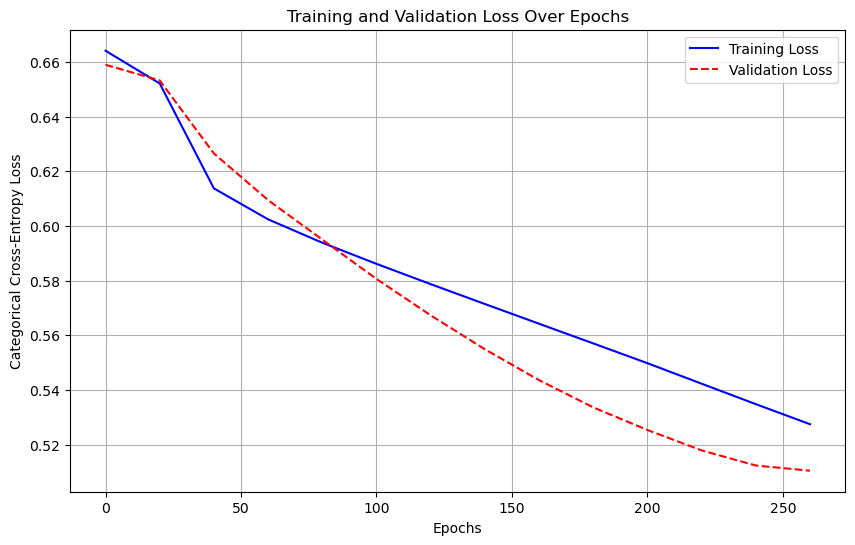

In [109]:
import matplotlib.pyplot as plt
# import numpy as np # Assumed imported

# 1. SETUP AND TRAINING CALL (Assuming X, Y, and train_val_split are defined)

# You must set these variables for the call:
EPOCHS = 250  # Example value ###1500 gives accuracy of 0.5 with hidden dim = 10, learning rate = 0.05
LEARNING_RATE = 0.1 # Example value
HIDDEN_DIM = 65 # Example value
HIDDEN_DIM_2 = 32 # Example value``
LOG_INTERVAL = 20 # How often to record loss

# Initialize NN (using dimensions from the split data)
INPUT_DIM = X_expert_train.shape[0]
OUTPUT_DIM = Y_expert_train_ohe.shape[0]

nnExpert = DeepNN(INPUT_DIM, HIDDEN_DIM, HIDDEN_DIM_2,  OUTPUT_DIM)

# Train the model and get the loss histories
train_loss, val_loss = nnExpert.train(
    X_expert_train, Y_expert_train_ohe,
    X_expert_val, Y_expert_val_ohe,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    log_interval=LOG_INTERVAL
)

# 1. Use the length of the actual data returned by the training
actual_length = len(train_loss)

# 2. Generate indices based on that length
# This ensures x and y are always the same size, regardless of EPOCHS settings
epochs_to_plot = np.arange(actual_length) * LOG_INTERVAL

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_plot, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_to_plot, val_loss, label='Validation Loss', color='red', linestyle='--')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig('loss_curve.png') # Use this if running in a non-interactive environment

In [121]:
# Predict on Training Set
train_preds_expert, train_preds_expert_proba = nnExpert.predict(X_expert_train)
# Convert Y_train from One-Hot (K, M) to Sparse (M,)
Y_train_sparse_expert = np.argmax(Y_expert_train_ohe, axis=0)
train_acc_expert = np.mean(train_preds_expert == Y_train_sparse_expert)

# Predict on Validation Set
val_preds_expert, val_preds_expert_proba = nnExpert.predict(X_expert_val)
# Convert Y_val from One-Hot (K, M) to Sparse (M,)
Y_val_sparse_expert = np.argmax(Y_expert_val_ohe, axis=0)
val_acc_expert = np.mean(val_preds_expert == Y_val_sparse_expert)

print(f"Training Accuracy:   {train_acc_expert * 100:.2f}%")
print(f"Validation Accuracy: {val_acc_expert * 100:.2f}%")

Training Accuracy:   76.97%
Validation Accuracy: 83.33%


In [122]:
# Predict on Training Set
train_preds_expert, train_preds_expert_proba = nnExpert.predict(X_train)
# Convert Y_train from One-Hot (K, M) to Sparse (M,)
Y_train_sparse_expert = np.argmax(Y_train, axis=0)
train_acc_expert = np.mean(train_preds_expert == Y_train_sparse_expert)

# Predict on Validation Set
val_preds_expert, val_preds_expert_proba = nnExpert.predict(X_val)
# Convert Y_val from One-Hot (K, M) to Sparse (M,)
Y_val_sparse_expert = np.argmax(Y_val, axis=0)
val_acc_expert = np.mean(val_preds_expert == Y_val_sparse_expert)

print(f"Training Accuracy:   {train_acc_expert * 100:.2f}%")
print(f"Validation Accuracy: {val_acc_expert * 100:.2f}%")

Training Accuracy:   42.80%
Validation Accuracy: 50.74%


In [123]:
import numpy as np

def map_expert_probas_to_full_matrix(expert_proba_2xM):
    """
    Converts the 2xM probability matrix from the Expert Network (predicting 
    original classes 1 and 4) into a 5xM matrix where all other class 
    probabilities are set to zero.

    :param expert_proba_2xM: NumPy array of shape (2, M). 
    :return: Full probability matrix of shape (5, M).
    """
    
    # 1. Determine the number of samples (M)
    M = expert_proba_2xM.shape[1]
    
    # 2. Initialize the final 5xM matrix with zeros
    # K_full = 5 (Classes 0, 1, 2, 3, 4)
    K_full = 5
    full_proba_5xM = np.zeros((K_full, M))
    
    # 3. Map the Expert's probabilities to the correct rows (original class indices)
    
    # Map Expert Row 0 (Original Class 1) to Full Row 1
    # full_proba_5xM[target_row, all_columns] = expert_source_row
    full_proba_5xM[1, :] = expert_proba_2xM[0, :]
    
    # Map Expert Row 1 (Original Class 4) to Full Row 4
    full_proba_5xM[4, :] = expert_proba_2xM[1, :]
    
    return full_proba_5xM

# --- EXAMPLE USAGE ---

# Assuming val_preds_expert_proba is your 2xM array:
val_preds_expert_proba = map_expert_probas_to_full_matrix(val_preds_expert_proba)

print(f"Output shape (Classes x Samples): {val_preds_expert_proba.shape}")


Output shape (Classes x Samples): (5, 203)


In [166]:
preds_proba_total = val_preds_expert_proba*0.15 + val_preds_proba*0.85

In [167]:
preds_proba_total

# Predict on Validation Set
val_preds_expert = np.argmax(preds_proba_total, axis=0)
# Convert Y_val from One-Hot (K, M) to Sparse (M,)
Y_val_sparse_expert = np.argmax(Y_val, axis=0)
val_acc_expert = np.mean(val_preds_expert == Y_val_sparse_expert)
val_acc_expert

0.541871921182266

In [40]:
import pickle

# Load the pickle file
with open('data/test_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Access images and labels
images_test = data['images']

In [41]:
# 1. Define the weights for R, G, B
rgb_weights = [0.299, 0.587, 0.114]
# This reduces the last dimension from 3 to 1
images_test = np.dot(images_test[..., :3], rgb_weights)

#images_test = np.mean(images_test, axis=3)



images_test = images_test.reshape(images_test.shape[0], -1)
images_test = images_test / 255.0
X_test = images_test.T  # Shape: (Features, Samples)


In [157]:
test_preds, test_preds_proba = nn.predict(X_test)
test_preds_expert, test_preds_proba_expert = nnExpert.predict(X_test)
test_preds_proba_expert = map_expert_probas_to_full_matrix(test_preds_proba_expert)
test_preds_proba_total = test_preds_proba * 0.85 + test_preds_proba_expert * 0.15

test_preds = np.argmax(test_preds_proba_total, axis=0)
test_preds


array([0, 1, 0, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 2, 0, 0, 0, 2, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2,
       3, 3, 0, 3, 0, 0, 0, 1, 0, 0, 0, 1, 4, 0, 0, 0, 1, 0, 3, 0, 0, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 0, 1,
       3, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 3, 0, 0, 0, 3, 2, 3, 0, 0, 0, 1,
       0, 1, 0, 0, 2, 0, 3, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 1, 0,
       3, 0, 0, 0, 3, 0, 0, 0, 0, 2, 2, 1, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 2, 0, 0, 1, 0, 0, 0, 3, 0, 3, 0, 3, 3, 3, 0, 0, 0, 0, 2, 3,
       0, 0, 1, 0, 1, 0, 1, 3, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 2, 3,
       0, 2, 3, 0, 3, 3, 2, 0, 4, 0, 0, 3, 0, 0, 0, 0, 1, 3, 0, 3, 2, 0,
       0, 0, 0, 0, 0, 3, 1, 0, 1, 0, 3, 1, 0, 0, 1, 0, 0, 1, 3, 2, 2, 3,
       1, 0, 0, 0, 0, 0, 2, 3, 3, 3, 0, 0, 0, 0, 0, 3, 1, 2, 3, 2, 0, 3,
       0, 0, 0, 3, 0, 1, 1, 1, 0, 3, 0, 2, 0, 3, 0,

In [168]:
import pandas as pd
import numpy as np

# 1. Create the DataFrame
submission = pd.DataFrame({
    'ID': range(1, len(test_preds)+1), # Adjust to range(1, ...) if you need 1-based indexing
    'Label': test_preds
})


# 3. Export
submission.to_csv('data/submission.csv', index=False)

print("\n--- Raw File Preview (First 5 lines) ---")
with open('data/submission.csv', 'r') as f:
    for _ in range(5):
        print(f.readline().strip())


--- Raw File Preview (First 5 lines) ---
ID,Label
1,0
2,1
3,0
4,0


## Evaluate Models

Analyze your best model's performance (see README.md for evaluation guidelines).

In [22]:
####################################################################
###############   TO complete   ####################################
####################################################################

## Generate Predictions for Kaggle Submission

Create a CSV file with columns: `id` and `quality` (see README.md for format details).

In [ ]:

####################################################################
###############   TO complete   ####################################
####################################################################

---
Good luck with the competition! 🍺
